# Exploratory Data Analysis
What the fuck we got goin' on here

In [1]:
import os
import glob

import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

from zenodo:
Filename identifiers 

- 01 -> Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- 02 -> Vocal channel (01 = speech, 02 = song).
- 03 -> Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- 04 -> Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- 05 -> Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- 06 -> Repetition (01 = 1st repetition, 02 = 2nd repetition).
- 07 -> Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).


In [2]:
modality = ['full-av', 'video-only', 'audio-only']
vocal_channel = ['speech', 'song']
emotion = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
intensity = ['normal', 'strong']

In [3]:
data_dir = '../data'
wav_paths = glob.glob(os.path.join(data_dir, 'Actor_*', '*.wav'))

rows = []
for p in wav_paths:
    fname = os.path.basename(p)
    # ravdess goes
    # modality - channel - emotion - intensity - statement - repetition - actor
    parts = fname.replace('.wav', '').split('-')
    rows.append({
        'path': p,
        'modality': parts[0],
        'vocal_channel': parts[1],
        'emotion': emotion[int(parts[2])-1],
        'intensity': parts[3],
        'statement': parts[4],
        'repetition': parts[5],
        'actor': parts[6]
    })

meta = pd.DataFrame(rows)
print(f"Total samples: {len(meta)}")
print("Emotions present:", sorted(meta['emotion'].unique()))
print("Counts by emotion:")
print(meta['emotion'].value_counts())

Total samples: 1440
Emotions present: ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Counts by emotion:
emotion
happy        192
surprised    192
disgust      192
calm         192
fearful      192
sad          192
angry        192
neutral       96
Name: count, dtype: int64


In [4]:
meta.head()

,path,modality,vocal_channel,emotion,intensity,statement,repetition,actor
0,../data/Actor_07/03-01-03-01-02-01-07.wav,03,01,happy,01,02,01,07
1,../data/Actor_07/03-01-08-02-02-02-07.wav,03,01,surprised,02,02,02,07
2,../data/Actor_07/03-01-08-01-01-02-07.wav,03,01,surprised,01,01,02,07
3,../data/Actor_07/03-01-07-02-01-01-07.wav,03,01,disgust,02,01,01,07
4,../data/Actor_07/03-01-03-01-01-02-07.wav,03,01,happy,01,01,02,07


In [5]:
def get_duration(path):
    return librosa.get_duration(path=path)

meta['duration'] = meta['path'].map(get_duration)

meta.describe()


,duration
count,1440.000000
mean,3.700665
std,0.336676
min,2.936271
25%,3.470146
50%,3.670333
75%,3.870542
max,5.271937


In [6]:
# get path with smallest duration
print(meta.loc[meta['duration'].idxmin()])

path             ../data/Actor_13/03-01-02-01-02-02-13.wav
modality                                                03
vocal_channel                                           01
emotion                                               calm
intensity                                               01
statement                                               02
repetition                                              02
actor                                                   13
duration                                          2.936271
Name: 1435, dtype: object


In [7]:
def get_mfcc(path):
    n_mfcc = 13
    y, sr = librosa.load(path, sr=16000)
    return librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

mfcc_shapes = []

for path in meta['path']:
    mfcc = get_mfcc(path)
    mfcc_shapes.append(mfcc.shape)

mfcc_shapes = pd.DataFrame(mfcc_shapes)
mfcc_shapes.describe()

,0,1
count,1440.0,1440.000000
mean,13.0,116.124306
std,0.0,10.480955
min,13.0,92.000000
25%,13.0,109.000000
50%,13.0,115.000000
75%,13.0,121.000000
max,13.0,165.000000


In [8]:
def get_chroma(path):
    n_mfcc = 13
    y, sr = librosa.load(path, sr=16000)
    return librosa.feature.chroma_stft(y=y, sr=sr)

chroma_shapes = []

for path in meta['path']:
    chroma = get_chroma(path)
    chroma_shapes.append(chroma.shape)

chroma_shapes = pd.DataFrame(chroma_shapes)
chroma_shapes.describe()

,0,1
count,1440.0,1440.000000
mean,12.0,116.124306
std,0.0,10.480955
min,12.0,92.000000
25%,12.0,109.000000
50%,12.0,115.000000
75%,12.0,121.000000
max,12.0,165.000000


MFCC shape: (13, 295)


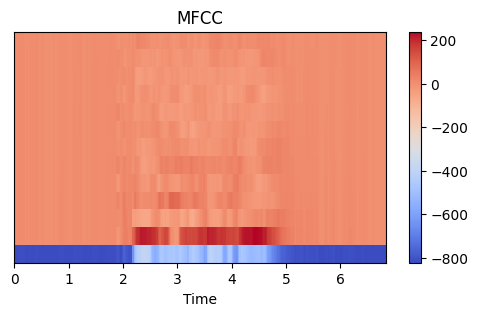

Chroma shape: (12, 295)


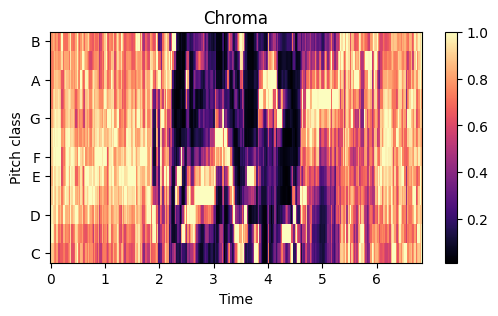

In [9]:
# pick one sample
path = meta['path'].iloc[-1]
y, sr = librosa.load(path, sr=None)

# MFCCs
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
print("MFCC shape:", mfcc.shape)  # (n_mfcc, frames)

plt.figure(figsize=(6,3))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.show()

# Chroma
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
print("Chroma shape:", chroma.shape)  # (12, frames)

plt.figure(figsize=(6,3))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chroma')
plt.show()

<Figure size 800x400 with 0 Axes>

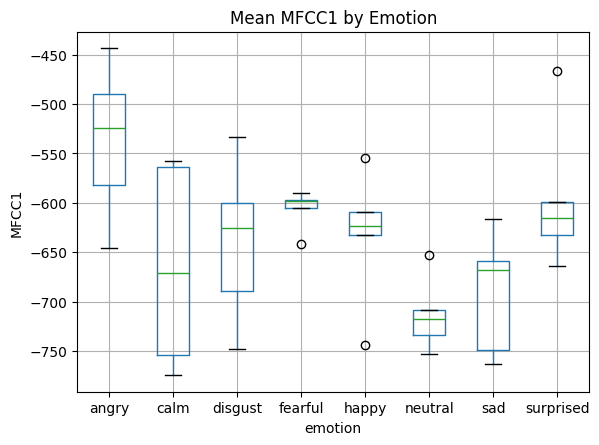

In [11]:
# for speed: sample a few files per emotion
grouped = meta.groupby('emotion').sample(5, random_state=0)

mfcc_stats = []
for _, row in grouped.iterrows():
    y, sr = librosa.load(row['path'], sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_stats.append({
        'emotion': row['emotion'],
        **{f'mfcc{i+1}_mean': mfcc[i].mean() for i in range(13)}
    })
mfcc_stats_df = pd.DataFrame(mfcc_stats)

# boxplot of, say, mfcc1_mean by emotion
plt.figure(figsize=(8,4))
mfcc_stats_df.boxplot(column='mfcc1_mean', by='emotion')
plt.title('Mean MFCC1 by Emotion')
plt.suptitle('')
plt.ylabel('MFCC1')
plt.show()

<Figure size 800x400 with 0 Axes>

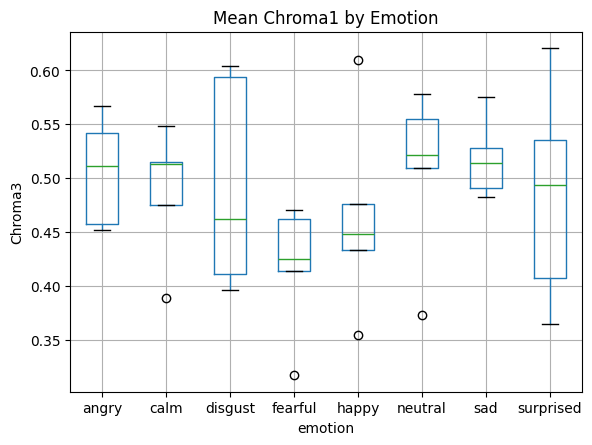

In [12]:
# for speed: sample a few files per emotion
grouped = meta.groupby('emotion').sample(5, random_state=0)

chroma_stats = []
for _, row in grouped.iterrows():
    y, sr = librosa.load(row['path'], sr=None)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12)
    chroma_stats.append({
        'emotion': row['emotion'],
        **{f'chroma{i+1}_mean': chroma[i].mean() for i in range(12)}
    })
chroma_stats_df = pd.DataFrame(chroma_stats)

# boxplot of, say, mfcc1_mean by emotion
plt.figure(figsize=(8,4))
chroma_stats_df.boxplot(column='chroma3_mean', by='emotion')
plt.title('Mean Chroma1 by Emotion')
plt.suptitle('')
plt.ylabel('Chroma3')
plt.show()

# DataLoader
I'm gonna make a feature vector with chroma and MFCC data, God willing.

In [13]:
emotions = sorted(meta['emotion'].unique())
emotion2idx = {emo: i for i, emo in enumerate(emotions)}

In [25]:
emotion2idx

{'angry': 0,
 'calm': 1,
 'disgust': 2,
 'fearful': 3,
 'happy': 4,
 'neutral': 5,
 'sad': 6,
 'surprised': 7}

In [14]:
from tqdm import tqdm  # for progress bar
import torch

# Hyper-params (must match what you use later)
SR = None
N_MFCC = 13
N_CHROMA = 12

# Lists to hold your tensors and labels
feats_cache = []
labels_cache = []

print("Pre-computing features…")
for _, row in tqdm(meta.iterrows(), total=len(meta)):
    y, sr = librosa.load(row['path'], sr=SR)
    mfcc   = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=N_CHROMA)
    feats  = np.vstack([mfcc, chroma]).T            # (frames, feat_dim)
    tensor = torch.from_numpy(feats).float()
    label  = torch.tensor(emotion2idx[row['emotion']], dtype=torch.long)
    feats_cache.append(tensor)
    labels_cache.append(label)
    # print(f"mfcc: {mfcc.shape}, chroma: {chroma.shape}, label: {row['emotion']}")

# Optionally save to disk for later sessions:
torch.save((feats_cache, labels_cache), "ravdess_feats.pt")
print("Done! Cached", len(feats_cache), "samples.")

Pre-computing features…


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1440/1440 [00:54<00:00, 26.23it/s]


Done! Cached 1440 samples.


# Cached DataLoader

Since I'm baller as fuck I precalculated all the chromosomes and mfcc's and saved it in a file to load later so I don't bog down my poor PC with doing a lot of math all the time

In [15]:
import torch
from torch.utils.data import Dataset
import librosa
import numpy as np

class CachedRAVDESSDataset(Dataset):
    def __init__(self, feats, labels):
        self.feats  = feats
        self.labels = labels

    def __len__(self):
        return len(self.feats)

    def __getitem__(self, idx):
        return self.feats[idx], self.labels[idx]

In [16]:
from torch.nn.utils.rnn import pad_sequence

def pad_collate(batch):
    """
    batch: list of (feat_tensor [T_i×D], label)
    returns:
      - feats: (B, T_max, D) padded with zeros
      - lengths: (B,) original T_i
      - labels: (B,)
    """
    feats, labels = zip(*batch)
    lengths = torch.tensor([f.shape[0] for f in feats], dtype=torch.long)
    # pad to the max T in this batch
    feats_padded = pad_sequence(feats, batch_first=True)  # zeros out the shorter ones
    labels = torch.stack(labels)
    return feats_padded, lengths, labels

In [17]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split, DataLoader

feats_cache, labels_cache = torch.load("ravdess_feats.pt")

# Instantiate dataset & DataLoader
dataset = CachedRAVDESSDataset(feats_cache, labels_cache)

train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size

# loader  = DataLoader(
#     dataset,
#     batch_size=32,
#     shuffle=True,
#     collate_fn=pad_collate,
#     num_workers=2,
#     pin_memory=False
# )

train_ds, val_ds = random_split(dataset,
                                [train_size, val_size],
                                generator=torch.Generator().manual_seed(42))


train_loader = DataLoader(train_ds,
                          batch_size=32,
                          shuffle=True,
                          collate_fn=pad_collate,
                          num_workers=2)

val_loader   = DataLoader(val_ds,
                          batch_size=32,
                          shuffle=False,
                          collate_fn=pad_collate,
                          num_workers=2)

In [18]:
for feats, lengths, labels in train_loader:
    print("Train loader")
    print("feats:", feats.shape)    # e.g. (32, T_max, 25)
    print("lengths:", lengths)      # e.g. tensor([200, 180, 240, …])
    print("labels:", labels.shape)  # (32,)
    break

for feats, lengths, labels in val_loader:
    print("Test loader")
    print("feats:", feats.shape)    # e.g. (32, T_max, 25)
    print("lengths:", lengths)      # e.g. tensor([200, 180, 240, …])
    print("labels:", labels.shape)  # (32,)
    break

Train loader
feats: torch.Size([32, 404, 25])
lengths: tensor([335, 360, 298, 392, 332, 323, 354, 348, 351, 357, 329, 354, 360, 316,
        345, 332, 338, 360, 304, 363, 345, 351, 341, 385, 332, 326, 313, 388,
        360, 332, 351, 404])
labels: torch.Size([32])
Test loader
feats: torch.Size([32, 463, 25])
lengths: tensor([313, 341, 376, 335, 401, 370, 323, 357, 345, 429, 357, 463, 363, 329,
        376, 345, 445, 366, 329, 407, 304, 376, 357, 338, 363, 329, 301, 320,
        370, 304, 385, 341])
labels: torch.Size([32])


In [19]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence

class CNNLSTMClassifier(nn.Module):
    def __init__(self,
                 input_features: int,
                 hidden_size: int,
                 num_layers: int,
                 num_classes: int,
                 bidirectional: bool = True,
                 dropout: float = 0.5):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 3), padding=(1, 1)),  # Conv2d: [B, 1, T, F] -> [B, 16, T, F]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),  # -> [B, 16, T//2, F//2]
            
            nn.Conv2d(16, 32, kernel_size=(3, 3), padding=(1, 1)),  # -> [B, 32, T//2, F//2]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),  # -> [B, 32, T//4, F//4]
        )

        self.lstm_input_size = 32 * (input_features // 4)  # Features after pooling
        self.lstm = nn.LSTM(input_size=self.lstm_input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            bidirectional=bidirectional,
                            batch_first=True,
                            dropout=dropout if num_layers > 1 else 0)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), num_classes)

    def forward(self, x, lengths):
        # x shape: [B, T, F]
        x = x.unsqueeze(1)  # [B, 1, T, F]
        x = self.conv(x)    # -> [B, 32, T//4, F//4]
        B, C, T_new, F_new = x.size()
        x = x.permute(0, 2, 1, 3).contiguous()  # [B, T_new, C, F_new]
        x = x.view(B, T_new, -1)  # [B, T_new, C * F_new] = ready for LSTM

        # Adjust lengths to account for two 2x pooling layers in time dimension
        lengths = lengths // 4
        # Make sure lengths are at least 1 and no greater than T_new
        lengths = torch.clamp(lengths, min=1, max=T_new)
        
        # Pack sequence
        packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_out, (h_n, c_n) = self.lstm(packed)

        if self.lstm.bidirectional:
            n_layers = self.lstm.num_layers
            H = self.lstm.hidden_size
            h_n = h_n.view(n_layers, 2, -1, H)
            h_fwd = h_n[-1, 0]
            h_bwd = h_n[-1, 1]
            h = torch.cat([h_fwd, h_bwd], dim=-1)
        else:
            h = h_n[-1]

        out = self.dropout(h)
        logits = self.fc(out)
        return logits


In [20]:
import torch.optim as optim

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, total_correct = 0.0, 0
    for feats, lengths, labels in loader:
        feats, lengths, labels = feats.to(device), lengths.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(feats, lengths)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == labels).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    accuracy = total_correct / len(loader.dataset)
    return avg_loss, accuracy

def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, total_correct = 0.0, 0
    with torch.no_grad():
        for feats, lengths, labels in loader:
            feats, lengths, labels = feats.to(device), lengths.to(device), labels.to(device)
            logits = model(feats, lengths)
            loss = criterion(logits, labels)

            total_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == labels).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    accuracy = total_correct / len(loader.dataset)
    return avg_loss, accuracy


In [ ]:
# 3.1 Hyper-parameters & setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size   = 13 + 12             # MFCCs + Chroma
hidden_size  = 128
num_layers   = 2
num_classes  = len(emotion2idx)
lr           = 1e-3
batch_size   = 32
num_epochs   = 100

# 3.2 Instantiate
model     = CNNLSTMClassifier(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# optional scheduler:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 mode='max',
                                                 patience=3,
                                                 factor=0.5)

# 3.3 Training loop
best_val_acc = 0.0
for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss,   val_acc   = eval_epoch(model, val_loader, criterion, device)  # or a separate val_loader

    log_line = (f"Epoch {epoch:02d}  "
            f"Train: loss={train_loss:.3f}, acc={train_acc:.3f}  "
            f"Val:   loss={val_loss:.3f}, acc={val_acc:.3f}")
    print(log_line)
    
    with open("training_log_cnn.txt", "a") as f:
        f.write(log_line + "\n")


    # step scheduler on val_acc
    scheduler.step(val_acc)

    # save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        print("Saving better model...")
        torch.save(model.state_dict(), "best_lstm_emotion_run_cnn.pth")

print(f"Best val acc: {best_val_acc:.3f}")

Epoch 01  Train: loss=2.059, acc=0.155  Val:   loss=2.007, acc=0.191
Saving better model...
Epoch 02  Train: loss=1.967, acc=0.226  Val:   loss=1.888, acc=0.212
Saving better model...
Epoch 03  Train: loss=1.904, acc=0.242  Val:   loss=1.865, acc=0.250
Saving better model...
Epoch 04  Train: loss=1.898, acc=0.240  Val:   loss=1.871, acc=0.226


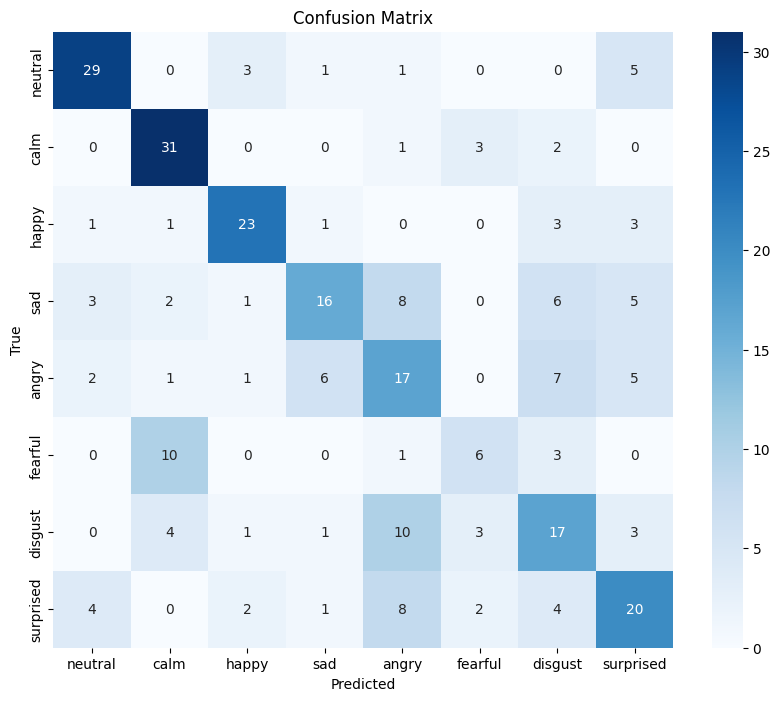

In [24]:
# 3.1 Hyper-parameters & setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size   = 13 + 12             # MFCCs + Chroma
hidden_size  = 128
num_layers   = 2
num_classes  = len(emotion2idx)
lr           = 1e-3
batch_size   = 32
num_epochs   = 100

# 3.2 Instantiate
model     = CNNLSTMClassifier(input_size, hidden_size, num_layers, num_classes).to(device)
model.load_state_dict(torch.load("best_lstm_emotion_run_cnn_preoverfitting.pth"))
model.to(device)
model.eval()  # Important! Put model in evaluation mode
from sklearn.metrics import confusion_matrix
import torch
import numpy as np

# Ensure the model is in evaluation mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for feats, lengths, labels in val_loader:
        feats = feats.to(device)
        lengths = lengths.to(device)
        labels = labels.to(device)

        outputs = model(feats, lengths)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
# print("Confusion Matrix:\n", cm)


import seaborn as sns
import matplotlib.pyplot as plt

# Class labels (optional, depends on your dataset)
labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [28]:
import torch
from sklearn.metrics import classification_report, precision_recall_fscore_support

# 1. Collect all predictions and true labels
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for feats, lengths, labels in val_loader:
        feats, lengths = feats.to(device), lengths.to(device)
        logits = model(feats, lengths)
        preds  = logits.argmax(dim=1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# 2. Print a full classification report
print(classification_report(
    y_true,
    y_pred,
    target_names=emotions,
    digits=4
))

# 3. If you want the raw arrays of precision/recall/F1 per class:
precisions, recalls, f1s, supports = precision_recall_fscore_support(
    y_true,
    y_pred,
    average=None  # returns one value per class
)

for emo, p, r, f, s in zip(emotions, precisions, recalls, f1s, supports):
    print(f"{emo}:  precision={p:.4f},  recall={r:.4f},  f1={f:.4f},  support={s}")

              precision    recall  f1-score   support

       angry     0.7436    0.7436    0.7436        39
        calm     0.6327    0.8378    0.7209        37
     disgust     0.7419    0.7188    0.7302        32
     fearful     0.6154    0.3902    0.4776        41
       happy     0.3696    0.4359    0.4000        39
     neutral     0.4286    0.3000    0.3529        20
         sad     0.4048    0.4359    0.4198        39
   surprised     0.4878    0.4878    0.4878        41

    accuracy                         0.5521       288
   macro avg     0.5530    0.5438    0.5416       288
weighted avg     0.5561    0.5521    0.5474       288

angry:  precision=0.7436,  recall=0.7436,  f1=0.7436,  support=39
calm:  precision=0.6327,  recall=0.8378,  f1=0.7209,  support=37
disgust:  precision=0.7419,  recall=0.7188,  f1=0.7302,  support=32
fearful:  precision=0.6154,  recall=0.3902,  f1=0.4776,  support=41
happy:  precision=0.3696,  recall=0.4359,  f1=0.4000,  support=39
neutral:  precis